# Setup & Library Import

In [179]:
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings(action="ignore")
pd.options.plotting.backend = "plotly"

from prophet import Prophet

In [180]:
FP_ELETRIC = "../data/eletric_consumption.csv"
FP_TAXI = "../data/nyc_taxi.csv"

In [10]:
def time_log(f):
    def wrapper(*args, **kwargs):
        tick = datetime.now()
        results = f(*args, **kwargs)
        tock = datetime.now()
        print(f"{f.__name__} function took {tock-tick}")
        return results
    wrapper.unwrapped = f
    return wrapper

# Load DataFrame

In [111]:
@time_log
def read_dataframe(filepath: str, delimiter: str=',') -> pd.DataFrame():
    """This function read dataframe 

    Args:
        filepath (str): the file_path directory

    Returns:
        df (pd.DataFrame): Time-series DataFrame
    """
    df = (pd.read_csv(filepath, parse_dates=True, delimiter=delimiter)
          .assign(timestamp = lambda x: pd.to_datetime(x.timestamp))
          .set_index(["timestamp"])
          .sort_index()
          )
    return df

In [112]:
df = read_dataframe(FP_ELETRIC, delimiter=';')
df.head()

read_dataframe function took 0:00:00.008799


timestamp    Min    Max
0   6.2.2020  11.53  14.48
1   7.2.2020   9.13  14.56
2   8.2.2020  12.00  12.25
3   9.2.2020  11.96  12.00
4  10.2.2020  11.94  14.89

# Preprocessing

## Feature Engineering

In [113]:
df["Range"] = df["Max"] - df["Min"]
df.head()

timestamp    Min    Max  Range
0   6.2.2020  11.53  14.48   2.95
1   7.2.2020   9.13  14.56   5.43
2   8.2.2020  12.00  12.25   0.25
3   9.2.2020  11.96  12.00   0.04
4  10.2.2020  11.94  14.89   2.95

In [115]:
day_name = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Satudary",
            "Sunday"]
df["Weekday"] = [day_name[i] for i in pd.to_datetime(df["timestamp"]).dt.dayofweek]
df.head()

timestamp    Min    Max  Range    Weekday
0   6.2.2020  11.53  14.48   2.95    Tuesday
1   7.2.2020   9.13  14.56   5.43   Thursday
2   8.2.2020  12.00  12.25   0.25     Sunday
3   9.2.2020  11.96  12.00   0.04  Wednesday
4  10.2.2020  11.94  14.89   2.95     Friday

# Exploratory Data Analysis

In [116]:
df.corr(method="pearson")

Min       Max     Range
Min    1.000000 -0.162836 -0.743711
Max   -0.162836  1.000000  0.780682
Range -0.743711  0.780682  1.000000

In [119]:
fig = df.set_index("timestamp")[["Min", "Max", "Range"]].plot(template="simple_white")
fig.show()

In [120]:
fig = df.set_index("timestamp")[["Min", "Max", "Range"]].hist(template="simple_white")
fig.show()

# Using Facebook's Prophet Model

In [132]:
@time_log
def anomaly_Phophet_model(feature: str):
    """This function build Phophet model and predicted

    Args:
        feature (str): feature that will be used to predict
    Returns:
        forecast (pd.DataFrame): Forecast dataframe
    """
    train_df = pd.DataFrame()
    train_df["ds"] = pd.to_datetime(df["timestamp"], dayfirst=True)
    
    train_df["y"] = df[[feature]].values
    horizont = 1

    model = Prophet(daily_seasonality=True)
    model.fit(train_df)
    
    future = model.make_future_dataframe(periods=horizont)
    forecast = model.predict(future)
    print(f"Forecasted feature: {feature}, \nValues:")
    display(forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail())
    pd.options.plotting.backend = "plotly"
    fig = model.plot(forecast)
    return forecast


17:02:17 - cmdstanpy - INFO - Chain [1] start processing
17:02:17 - cmdstanpy - INFO - Chain [1] done processing


Forecasted feature: Range, 
Values:


ds      yhat  yhat_lower  yhat_upper
86 2020-05-02 -0.302693   -2.048346    1.596517
87 2020-05-03 -0.372687   -2.068790    1.321506
88 2020-05-04  0.467309   -1.279935    2.207660
89 2020-05-05  0.908078   -0.816057    2.734768
90 2020-05-06 -0.010424   -1.666396    1.821314

anomaly_Phophet_model function took 0:00:00.278062
Anomalies for range values


Weekday  Range  Range_Prophet
1    Thursday   5.43       4.064971
5      Monday   5.49       4.566266
6   Wednesday   3.65       3.569897
23   Satudary   3.52       2.896905
42   Thursday   6.27       3.533172
45     Sunday   4.09       2.450655
51   Satudary   2.61       2.120030
63     Friday   3.33       3.095486
70   Thursday   5.95       3.003360
88     Sunday   4.90       2.207660

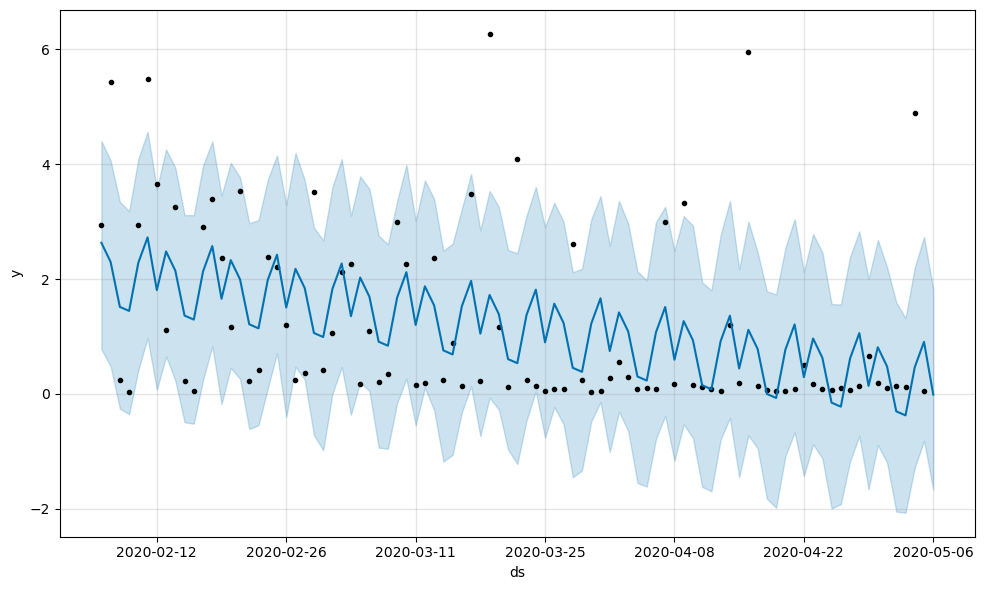

In [133]:
forecast = anomaly_Phophet_model("Range")
df["Range_Prophet"] = forecast["yhat_upper"]
print("Anomalies for range values")
display(df[df["Range"] > df["Range_Prophet"]][["Weekday", "Range", "Range_Prophet"]])

17:02:22 - cmdstanpy - INFO - Chain [1] start processing
17:02:22 - cmdstanpy - INFO - Chain [1] done processing


Forecasted feature: Min, 
Values:


ds       yhat  yhat_lower  yhat_upper
86 2020-05-02  11.402336   10.138097   12.663632
87 2020-05-03  11.447727   10.278670   12.748257
88 2020-05-04  11.347683   10.068512   12.595357
89 2020-05-05  11.297657    9.963686   12.568597
90 2020-05-06  11.703489   10.428726   13.021953

anomaly_Phophet_model function took 0:00:00.303094
Anomalies for range values


Weekday    Min  Min_Prophet
0     Tuesday  11.53    10.185683
2      Sunday  12.00    10.410962
3   Wednesday  11.96    10.420055
4      Friday  11.94    10.223773
7    Thursday  11.29    10.103115
..        ...    ...          ...
84   Thursday  11.75     9.826425
85     Sunday  11.63    10.146153
86  Wednesday  11.58    10.138097
87   Thursday  11.47    10.278670
89    Tuesday  11.80     9.963686

[80 rows x 3 columns]

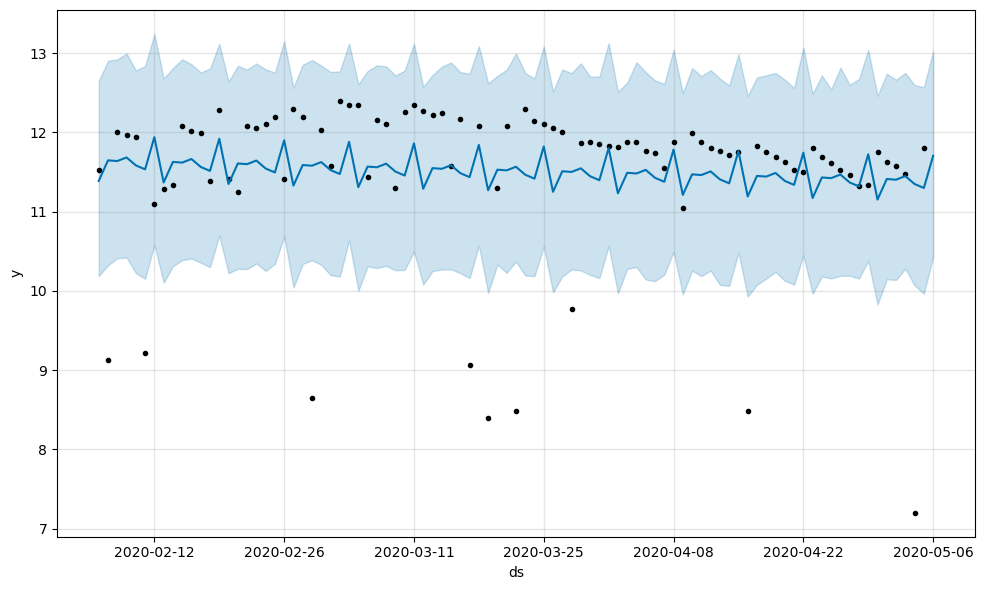

In [134]:
forecast = anomaly_Phophet_model("Min")
df["Min_Prophet"] = forecast["yhat_lower"]
print("Anomalies for range values")
display(df[df["Range"] < df["Range_Prophet"]][["Weekday", "Min", "Min_Prophet"]])

17:02:23 - cmdstanpy - INFO - Chain [1] start processing
17:02:23 - cmdstanpy - INFO - Chain [1] done processing


Forecasted feature: Max, 
Values:


ds       yhat  yhat_lower  yhat_upper
86 2020-05-02  11.092664   10.083514   12.101422
87 2020-05-03  11.068081   10.055669   12.032233
88 2020-05-04  11.812582   10.802635   12.829417
89 2020-05-05  12.205810   11.293070   13.213652
90 2020-05-06  11.689976   10.717900   12.676505

anomaly_Phophet_model function took 0:00:00.284359
Anomalies for range values


Weekday    Max  Max_Prophet
4      Friday  14.89    14.844360
6   Wednesday  14.75    14.690177
11     Monday  14.89    14.747612
13  Wednesday  14.64    14.457756
15     Friday  14.79    14.571374
27     Friday  14.61    14.240117
32   Thursday  14.30    14.203027
33   Satudary  14.51    14.482070
36     Friday  14.58    14.055301
42   Thursday  14.67    14.029252
61   Satudary  14.54    13.905155
63     Friday  14.37    13.466737
70   Thursday  14.44    13.238783

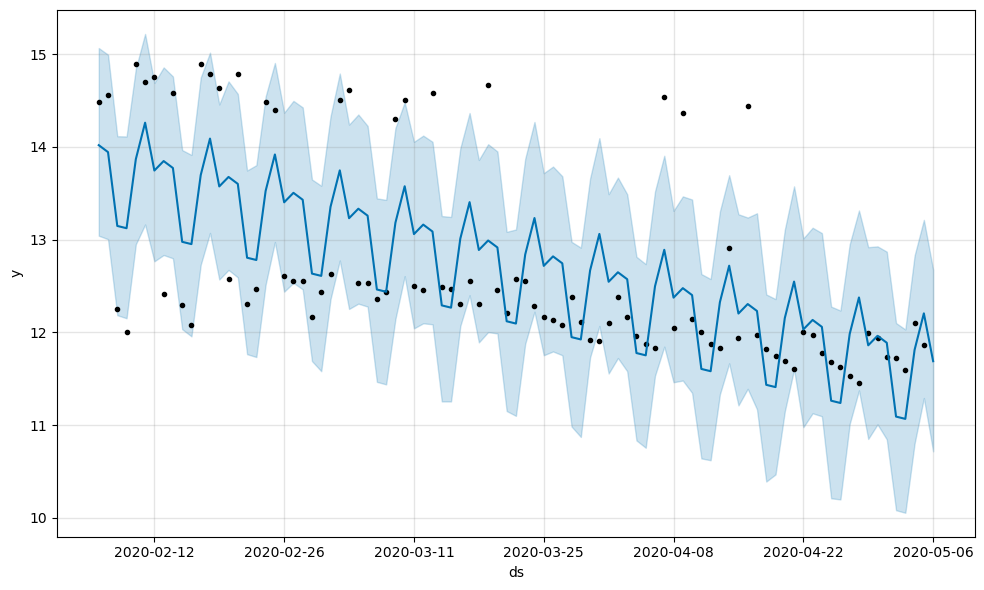

In [135]:
forecast = anomaly_Phophet_model("Max")
df["Max_Prophet"] = forecast["yhat_upper"]
print("Anomalies for range values")
display(df[df["Max"] > df["Max_Prophet"]][["Weekday", "Max", "Max_Prophet"]])

## Compare the predictions with collected data

In [136]:
fig = df.plot(x="timestamp", y=['Min','Max', 'Min_Prophet','Max_Prophet'], title="comparison", template="simple_white")
fig.show()

# Using in NYC Taxis Demand

In [137]:
df = pd.read_csv(FP_TAXI)
df.head()

timestamp  value
0  2014-07-01 00:00:00  10844
1  2014-07-01 00:30:00   8127
2  2014-07-01 01:00:00   6210
3  2014-07-01 01:30:00   4656
4  2014-07-01 02:00:00   3820

17:03:11 - cmdstanpy - INFO - Chain [1] start processing
17:03:11 - cmdstanpy - INFO - Chain [1] done processing


Forecasted feature: value, 
Values:


ds          yhat    yhat_lower    yhat_upper
10316 2015-01-31 22:00:00  21118.458754  16521.530343  26093.156250
10317 2015-01-31 22:30:00  19886.129137  14967.222782  24429.159735
10318 2015-01-31 23:00:00  18612.256336  14057.379489  23320.158799
10319 2015-01-31 23:30:00  17311.608825  12444.257539  21914.032024
10320 2015-02-01 23:30:00  13207.100660   8646.646712  18233.821859

anomaly_Phophet_model function took 0:00:02.136981


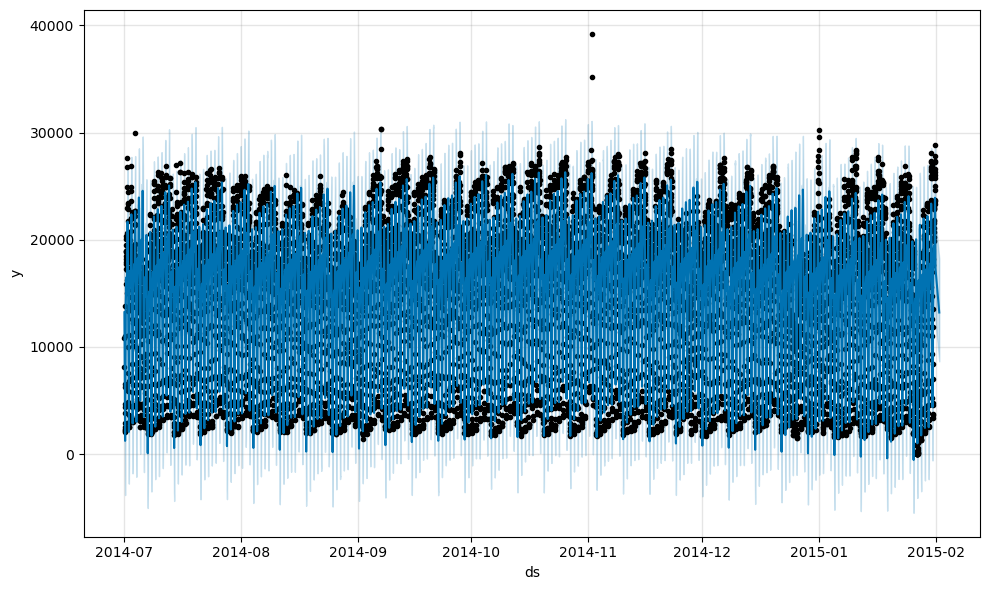

In [138]:
forecast = anomaly_Phophet_model("value")

In [139]:
df["value_Prophet"] = forecast["yhat"]
df["min_Prophet"] = forecast["yhat_lower"]
df["max_Prophet"] = forecast["yhat_upper"]
df.head()

timestamp  value  value_Prophet  min_Prophet   max_Prophet
0  2014-07-01 00:00:00  10844   13226.211908  8380.130481  17785.966650
1  2014-07-01 00:30:00   8127   11877.961209  7245.218848  16989.448650
2  2014-07-01 01:00:00   6210   10363.747205  5677.287052  15226.803677
3  2014-07-01 01:30:00   4656    8670.780584  3795.797167  13119.351187
4  2014-07-01 02:00:00   3820    6848.657763  2016.398961  11756.289022

In [141]:
df["timestamp"] = pd.to_datetime(df["timestamp"], dayfirst=True)

In [142]:
fig = df.plot(x="timestamp", y=["value", "min_Prophet", "max_Prophet", "value_Prophet"], title="comparison", template="simple_white")
fig.show()

In [143]:
df.head()

timestamp  value  value_Prophet  min_Prophet   max_Prophet
0 2014-07-01 00:00:00  10844   13226.211908  8380.130481  17785.966650
1 2014-07-01 00:30:00   8127   11877.961209  7245.218848  16989.448650
2 2014-07-01 01:00:00   6210   10363.747205  5677.287052  15226.803677
3 2014-07-01 01:30:00   4656    8670.780584  3795.797167  13119.351187
4 2014-07-01 02:00:00   3820    6848.657763  2016.398961  11756.289022

In [145]:
print(f'Mean: {df["value"].mean()}')
print(f'Standard Deviation: {df["value"].std()}')
max_value = df["value"].mean()+2*df["value"].std()
print(f"Expected maximum value: {max_value}")
df["value_calculated"] = max_value
print('Anamolies for Range values')
display(df[df['value']>df['value_calculated']][["timestamp","value","value_calculated"]])


Mean: 15137.569379844961
Standard Deviation: 6939.495808067999
Expected maximum value: 29016.56099598096
Anamolies for Range values


timestamp  value  value_calculated
134  2014-07-03 19:00:00  29985      29016.560996
3261 2014-09-06 22:30:00  30313      29016.560996
3262 2014-09-06 23:00:00  30373      29016.560996
5954 2014-11-02 01:00:00  39197      29016.560996
5955 2014-11-02 01:30:00  35212      29016.560996
8833 2015-01-01 00:30:00  29547      29016.560996
8834 2015-01-01 01:00:00  30236      29016.560996

## Compare the predictions with collected data

In [151]:
df.tail(1)

timestamp  value  value_Prophet   min_Prophet   max_Prophet  \
10319 2015-01-31 23:30:00  26288   17311.608825  12444.257539  21914.032024   

       value_calculated  
10319      29016.560996

In [154]:
fig = df.plot(title="Comparison", x="timestamp",y=["value", "value_calculated"], template="simple_white")
fig.show()

In [156]:
anomaly_df = pd.DataFrame()
anomaly_df = df[["timestamp", "value"]].copy()


In [177]:
anomaly_df["value_anomaly_Prophet"] = df["value_Prophet"]
anomaly_df["is_anomaly"] = df["value_Prophet"]

In [178]:
anomaly_df.head()

timestamp  value  value_anomaly_Prophet    is_anomaly
0 2014-07-01 00:00:00  10844           13226.211908  13226.211908
1 2014-07-01 00:30:00   8127           11877.961209  11877.961209
2 2014-07-01 01:00:00   6210           10363.747205  10363.747205
3 2014-07-01 01:30:00   4656            8670.780584   8670.780584
4 2014-07-01 02:00:00   3820            6848.657763   6848.657763

In [181]:
anomaly_df["is_anomaly"][df["value"]>df["value_Prophet"]] = True
anomaly_df["is_anomaly"][df["value"]<=df["value_Prophet"]]= False

In [182]:
anomaly_df.head(11)

timestamp  value  value_anomaly_Prophet is_anomaly
0  2014-07-01 00:00:00  10844           13226.211908      False
1  2014-07-01 00:30:00   8127           11877.961209      False
2  2014-07-01 01:00:00   6210           10363.747205      False
3  2014-07-01 01:30:00   4656            8670.780584      False
4  2014-07-01 02:00:00   3820            6848.657763      False
5  2014-07-01 02:30:00   2873            5016.381617      False
6  2014-07-01 03:00:00   2369            3349.431436      False
7  2014-07-01 03:30:00   2064            2048.950265       True
8  2014-07-01 04:00:00   2221            1300.084947       True
9  2014-07-01 04:30:00   2158            1229.714773       True
10 2014-07-01 05:00:00   2515            1874.354913       True